# Dataset cleanup

## Biblioteki

In [0]:
# Put these at the top of every notebook, to get automatic reloading
%reload_ext autoreload
%autoreload 2

#matplotlib setup
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')
mpl.style.use('seaborn-ticks')
# %config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import shutil as sh

# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots_wcz import *

from pathlib import Path

from  collections import Counter

from sklearn.metrics import confusion_matrix

## Mój dataset: 'Old Polish Cars v4'

In [0]:
dataset_path = Path('/content/data/old_polish_cars')
PATH = dataset_path / 'old_polish_cars_v5_photos-split/'

In [3]:
ls -lah $dataset_path

total 4.8G
drwxr-xr-x  4 root      root      4.0K Apr 28 20:06 ./
drwxr-xr-x  3 root      root      4.0K Apr 28 16:32 ../
drwxr-xr-x 12 349452163 349400513 4.0K Apr 28 19:09 old_polish_cars_v4_photos/
-rw-r--r--  1 root      root      2.4G Apr 28 20:06 old_polish_cars_v4_photos-20180428.tgz
drwxr-xr-x  7 349452163 349400513 4.0K Apr  9 21:23 old_polish_cars_v5_photos-split/
-rw-r--r--  1 root      root      2.4G Apr 28 20:14 old_polish_cars_v5_photos-split-2017-11-15.tgz


In [4]:
ls $PATH/train

Autobus Jelcz MZK/     Fiat 126p Maluch/  FSO Warszawa/  ZSD Nysa/
Autobus Jelcz Ogorek/  FSC Zuk/           Gazik/
Fiat 125p/             FSO Polonez/       Syrena 105/


In [0]:
cleanup_dataset_path = dataset_path / 'old_polish_cars_v4_photos/'

In [0]:
cats = sorted(list([x.stem for x in cleanup_dataset_path.iterdir()])) #; cats

In [7]:
cats_dict = {cat: idx for idx, cat in enumerate(cats)}; cats_dict

{'Autobus Jelcz MZK': 0,
 'Autobus Jelcz Ogorek': 1,
 'FSC Zuk': 2,
 'FSO Polonez': 3,
 'FSO Warszawa': 4,
 'Fiat 125p': 5,
 'Fiat 126p Maluch': 6,
 'Gazik': 7,
 'Syrena 105': 8,
 'ZSD Nysa': 9}

## Kategoria

In [0]:
#@title Kategoria
selected_cat = "Syrena 105" #@param ['Autobus Jelcz MZK', 'Autobus Jelcz Ogorek', 'FSC Zuk', 'FSO Polonez', 'FSO Warszawa', 'Fiat 125p', 'Fiat 126p Maluch', 'Gazik', 'Syrena 105', 'ZSD Nysa']


In [9]:
selected_cat_idx = cats_dict[selected_cat]
selected_cat_path = cleanup_dataset_path / cats[selected_cat_idx]; print(selected_cat_path)

print('{} items'.format(len(list(selected_cat_path.iterdir()))))

/content/data/old_polish_cars/old_polish_cars_v4_photos/Syrena 105
992 items


## Model

In [0]:
arch=resnet34
sz=224

tfms = tfms_from_model(arch, sz)

data = ImageClassifierData.from_paths(PATH, test_name=selected_cat_path, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [0]:
learn.precompute=False
# learn.load('224_lastlayer')
learn.load('224_all')

## Predykcja z zawartości foldera

In [0]:
log_preds = learn.predict(is_test=True)

preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds);            # pr(car) # probs[:10]
selected_y = np.full_like(preds, selected_cat_idx) #; selected_y[:10]

preds_classes = [data.classes[pred] for pred in preds] #; preds_classes[:10]
cat_classes = sorted(list(set(preds))) #; cat_classes
pred_probs = np.array([(pred, probs[pred]) for pred,probs in zip(preds, probs)]) #; pred_probs[:10]

In [13]:
accuracy_np(probs, selected_y)

0.8870967741935484

In [14]:
dict(Counter(preds_classes))

{'Autobus Jelcz MZK': 1,
 'Autobus Jelcz Ogorek': 6,
 'FSC Zuk': 6,
 'FSO Polonez': 16,
 'FSO Warszawa': 26,
 'Fiat 125p': 13,
 'Fiat 126p Maluch': 4,
 'Gazik': 22,
 'Syrena 105': 880,
 'ZSD Nysa': 18}

## Przegląd zdjęć

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == selected_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH/ds.fnames[idx]))

def plot_val_with_title(idxs, title):  
    imgs = [load_img_id(data.test_ds,x) for x in idxs]
    def fn(x): return Path(data.test_ds.fnames[x]).stem
    def pred_str(x): return '' + data.classes[int(pred_probs[x, 0])] + f', {pred_probs[x, 1]*100:0.4}%'
    title_probs = [pred_str(x) for x in idxs]
    titles = [f'{fn(x)} -> {pred_str(x)}' for x in idxs]
    print(title)
    print(titles)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified
['Syrena.104.000148 -> Syrena 105, 100.0%', 'Syrena.104.000232 -> Syrena 105, 100.0%', 'Syrena.104.000095 -> Syrena 105, 99.94%', 'Syrena.103.000280 -> Syrena 105, 99.84%']


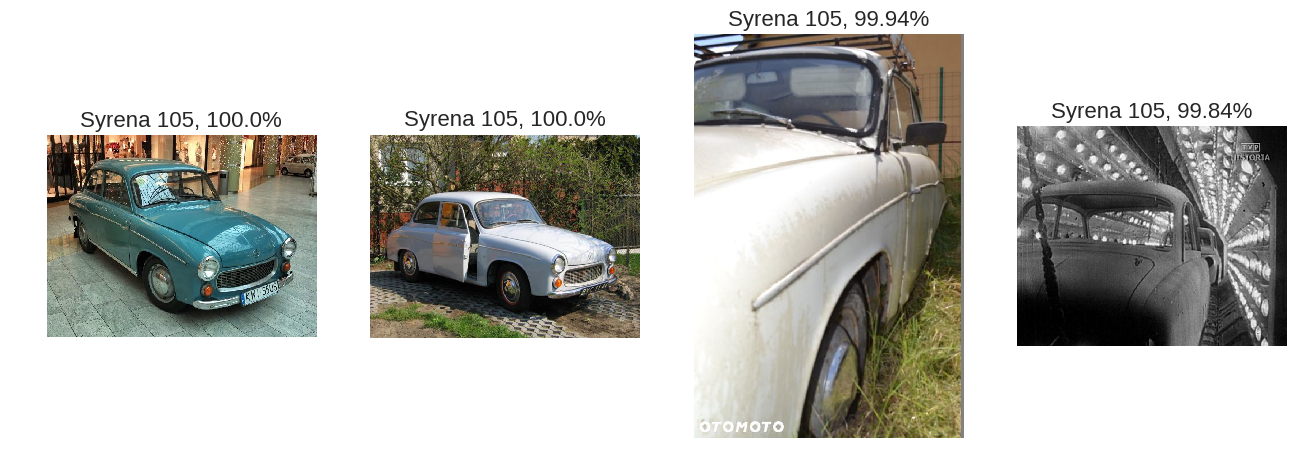

In [21]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified
['Syrena.105.000013 -> Fiat 126p Maluch, 49.13%', 'Syrena.105.000306 -> ZSD Nysa, 30.38%', 'Syrena.104.000013 -> Gazik, 69.59%', 'Syrena.105.000100 -> Autobus Jelcz Ogorek, 55.21%']


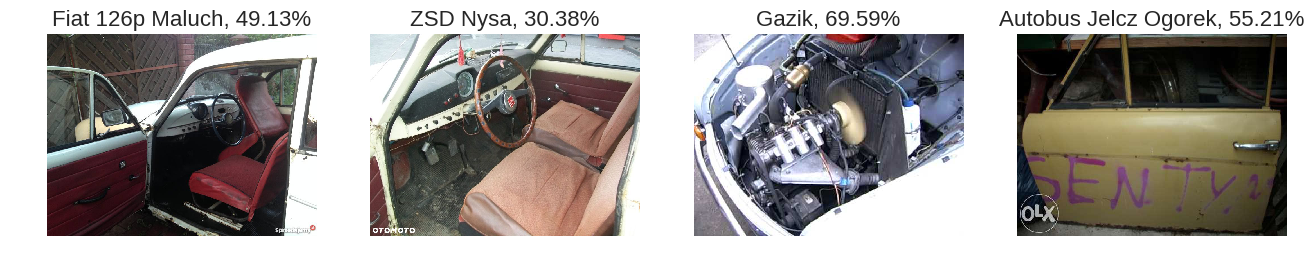

In [22]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * pred_probs[idxs, 1])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==selected_cat_idx)==is_correct else 1
    return most_by_mask((preds == selected_y)==is_correct & (selected_y == y), mult)

Most correct Syrena 105
['Syrena.103.000118 -> Syrena 105, 100.0%', 'Syrena.105.000226 -> Syrena 105, 100.0%', 'Syrena.103.000117 -> Syrena 105, 100.0%', 'Syrena.103.000138 -> Syrena 105, 100.0%']


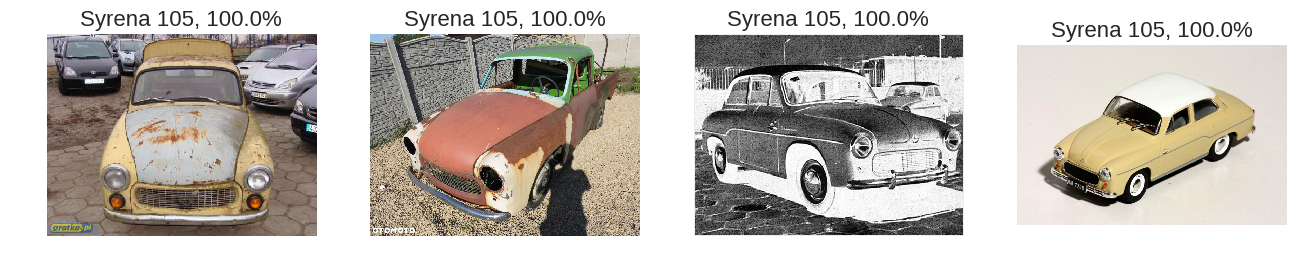

In [24]:
plot_val_with_title(most_by_correct(selected_cat_idx, True), "Most correct " + selected_cat)

Most incorrect Syrena 105
['Syrena.104.000380 -> FSO Warszawa, 21.8%', 'Syrena.103.000271 -> Autobus Jelcz Ogorek, 28.88%', 'Syrena.105.000306 -> ZSD Nysa, 30.38%', 'Syrena.104.000008 -> FSO Warszawa, 30.46%']


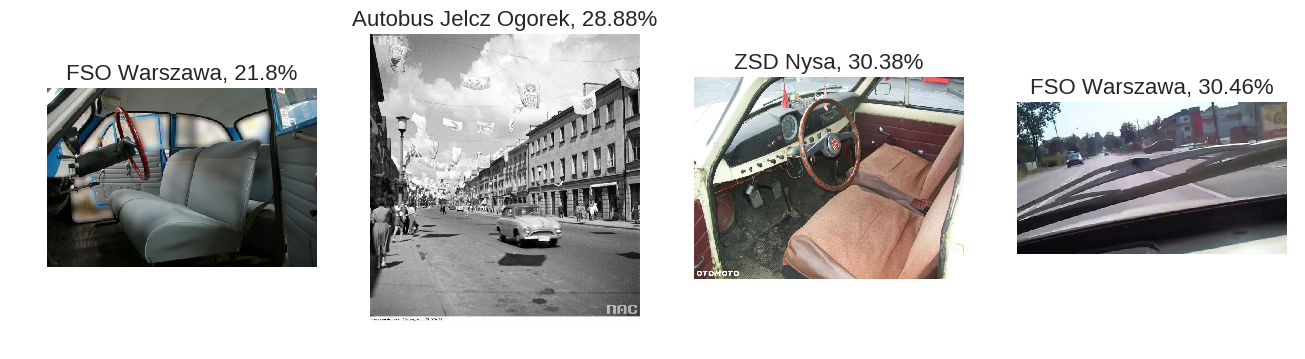

In [25]:
plot_val_with_title(most_by_correct(selected_cat_idx, False), "Most incorrect " + selected_cat)

Most uncertain predictions
['Syrena.104.000036 -> Gazik, 50.43%', 'Syrena.105.000013 -> Fiat 126p Maluch, 49.13%', 'Syrena.104.000091 -> Gazik, 49.0%', 'Syrena.104.000215 -> Gazik, 48.88%']


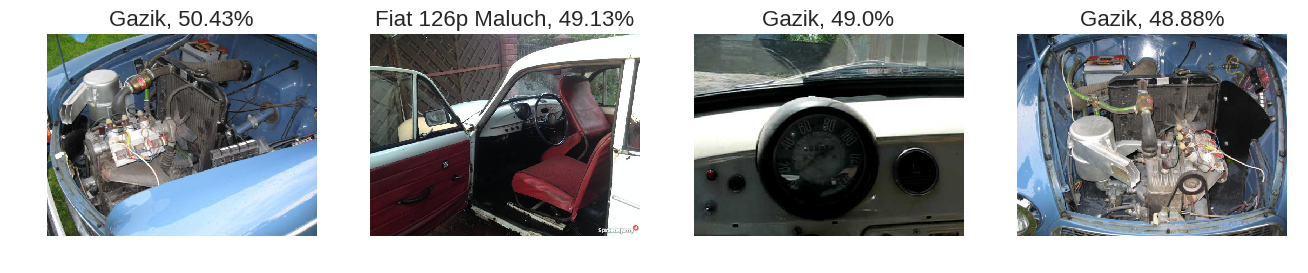

In [26]:
most_uncertain = np.argsort(np.abs(pred_probs[:, 1] -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")